In [31]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

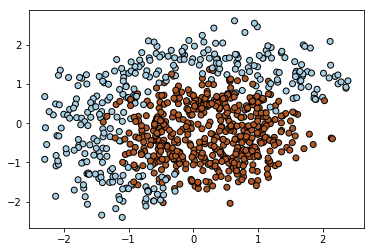

In [32]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [33]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, loss, n_iter):
    plt.clf()
    fig = plt.figure(figsize=(20, 8))
    
    with tf.Session() as sess:
        Z = sess.run(classify(np.c_[xx.ravel(), yy.ravel()], w))
        
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close(fig)


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [34]:
def expand(X):
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones_like(X0)], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    expand_X = expand(X)
    row_predictions = tf.reduce_sum(expand_X * w, axis=1)
    
    ones = tf.ones(X.shape[0])
    zeros = tf.zeros(X.shape[0])
    
    return tf.where(row_predictions > 0.5, ones, zeros)

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [35]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    expand_X = expand(X)
    row_predictions = tf.matmul(tf.expand_dims(w, 0), tf.transpose(expand_X))
    y_row_predictions = y*row_predictions
    max_array = tf.maximum(1 - y_row_predictions, 0)
    return 1.0/tf.to_float(tf.shape(X)[0]) * tf.reduce_sum(max_array)
    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    expand_X = expand(X)
    
    row_predictions = tf.squeeze(tf.matmul(tf.expand_dims(w, 0), tf.transpose(expand_X)))
    y_row_predictions = y*row_predictions
    max_array = tf.maximum(1 - y_row_predictions, 0)
    
    derative = tf.transpose(-1.0/tf.to_float(tf.shape(X)[0]) * y * tf.transpose(expand_X))
    each_grad = tf.where(tf.equal(max_array, 0), tf.zeros_like(derative), derative)
    return tf.reduce_sum(each_grad, axis=0)

In [36]:
# XX = tf.constant([[1, 1], [2, 1], [0, 0], [1, 1]], dtype=tf.float32)
# yy = tf.constant([1, -1, 1, 1], dtype=tf.float32)
# ww = tf.constant([0.5, 0.1, -0.3, 0.1, 0.2, 0.6])
# cp = compute_grad(XX, yy, ww)

# with tf.Session() as sess:
#     res = sess.run(cp)
#     print(res)

### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

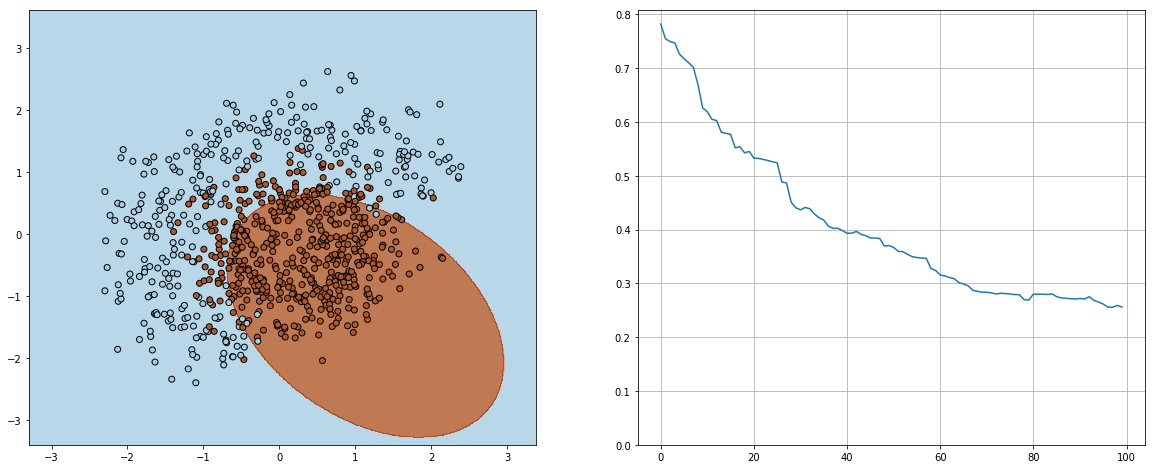

In [37]:
alpha = 0.05 # learning rate

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
update_weights = w_tf.assign(w_tf - alpha*loss_grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run(update_weights, {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

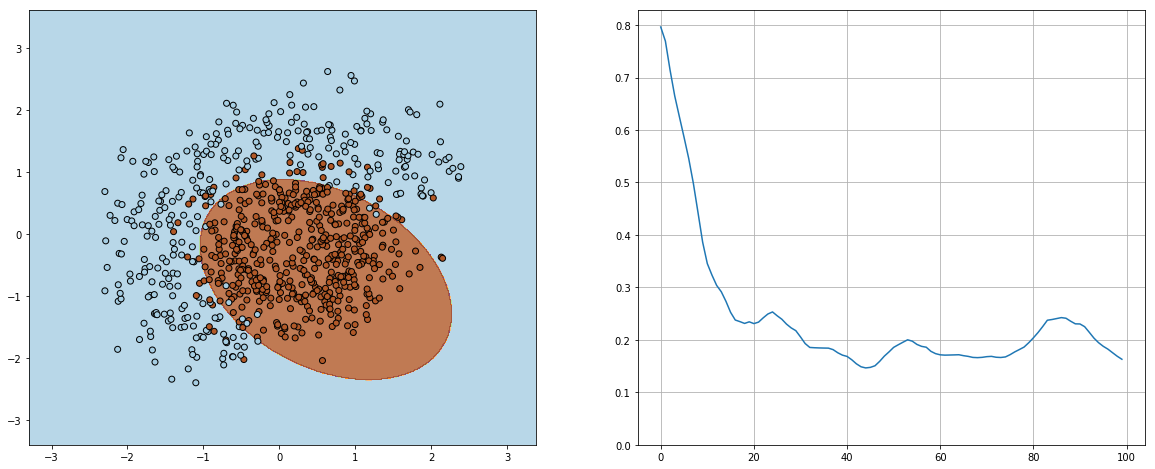

In [38]:
alpha = 0.05 # learning rate
mu    = 0.9 # momentum

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
update_weights = w_tf.assign(w_tf + momentum_tf)
update_momentum = momentum_tf.assign(momentum_tf*mu - alpha*loss_grad)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        _, _ = sess.run([update_momentum, update_weights], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])
    
visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

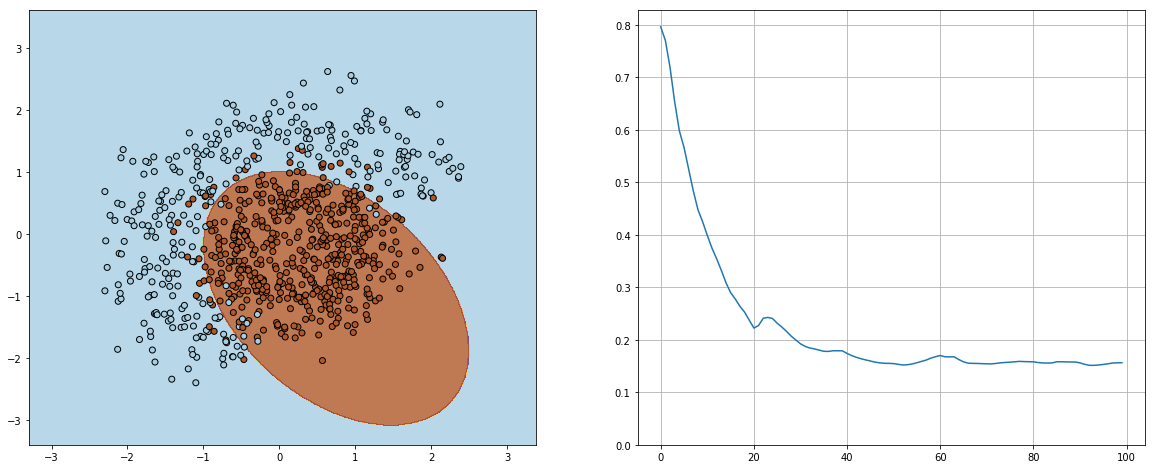

In [39]:
alpha = 0.05 # learning rate
mu    = 0.9 # momentum

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
update_weights_momentum = w_tf.assign(w_tf + momentum_tf)
update_weights_gradient = w_tf.assign(w_tf - alpha*loss_grad)
update_momentum = momentum_tf.assign(momentum_tf*mu - alpha*loss_grad)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run([update_momentum, update_weights_momentum, update_weights_gradient], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])
visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaGrad:

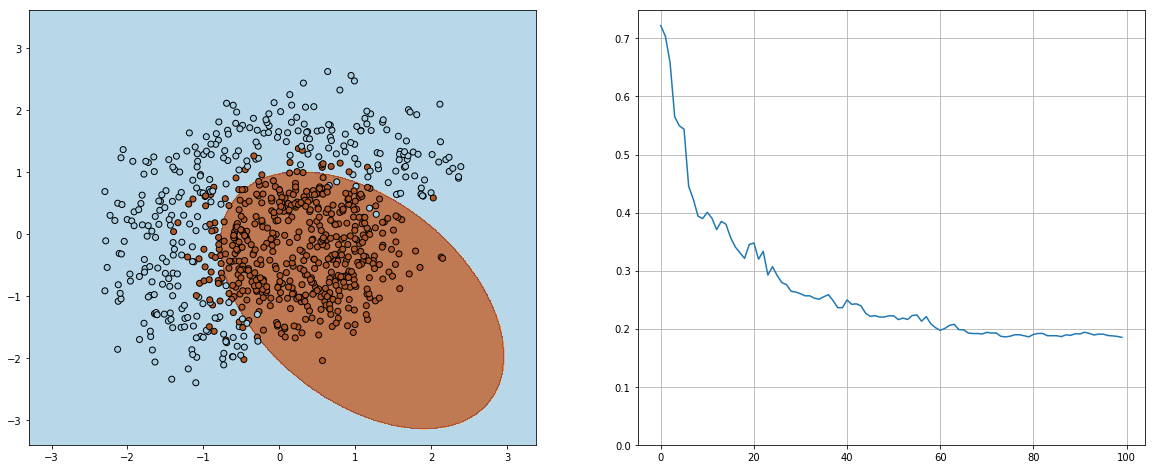

In [40]:
alpha = 0.3 # learning rate
mu    = 0 # momentum
eps = 1e-8  # A small constant for numerical stability

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
cw_tf = tf.Variable([1, 1, 1, 1, 1, 1], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
coef_tf = tf.div(alpha, (tf.sqrt(cw_tf) + eps))
update_weights = w_tf.assign(w_tf - coef_tf * loss_grad)
update_cw = cw_tf.assign(cw_tf + loss_grad*loss_grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run([update_weights, update_cw], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaDelta:

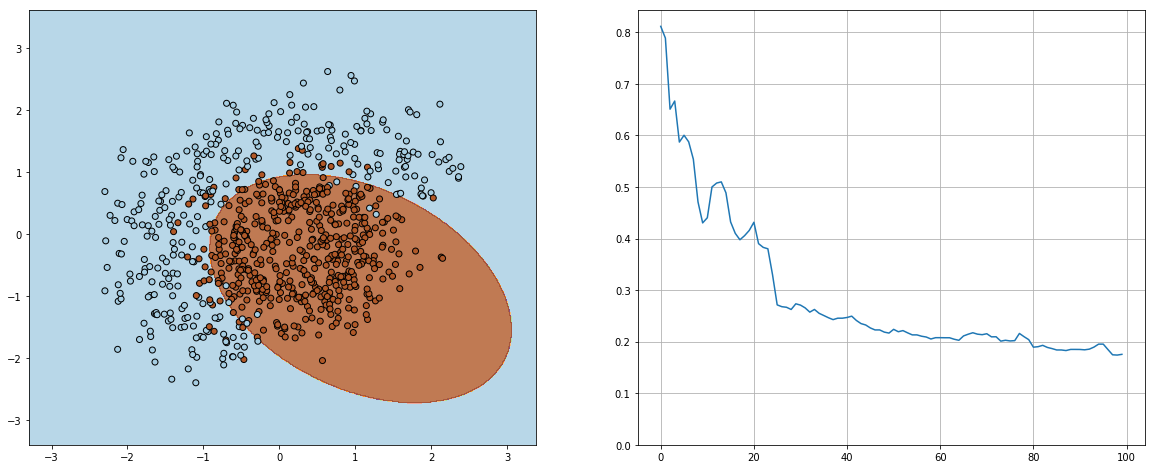

In [41]:
alpha = 0.3 # learning rate
beta = 0.99
gamma    = 0.7 # coeff
eps = 1e-8  # A small constant for numerical stability

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
cw_tf = tf.Variable([1, 1, 1, 1, 1, 1], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
coef_tf = tf.div(alpha, (tf.sqrt(cw_tf) + eps))
update_weights = w_tf.assign(w_tf - coef_tf * loss_grad)
update_cw = cw_tf.assign(cw_tf + loss_grad*loss_grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run([update_weights, update_cw], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])
visualize(X, y, w, loss, n_iter)
plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

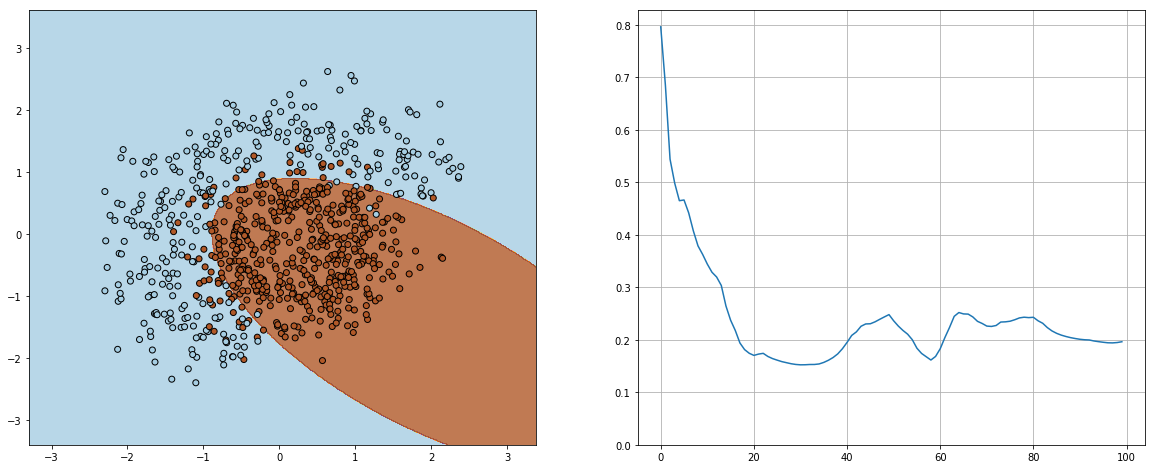

In [42]:
alpha = 0.05 # learning rate
beta = 0.9  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.999  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

w_tf = tf.Variable([1,0,0,0,0,0], dtype=tf.float32)
cw_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
momentum_tf = tf.Variable([0, 0, 0, 0, 0, 0], dtype=tf.float32)
X_tf = tf.placeholder(dtype=tf.float32, name="X")
y_tf = tf.placeholder(dtype=tf.float32, name="Y")

loss_tf = compute_loss(X_tf, y_tf, w_tf)
loss_grad = compute_grad(X_tf, y_tf, w_tf)
update_momentum = momentum_tf.assign(beta*momentum_tf + (1 - beta)*loss_grad)
update_weights = w_tf.assign(w_tf - alpha/(tf.sqrt(cw_tf) + eps) * momentum_tf)
update_cw = cw_tf.assign(cw_tf*mu + (1 - mu)*loss_grad*loss_grad)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        sess.run([update_cw, update_momentum, update_weights], {X_tf: X[ind, :], y_tf: y[ind]})
        loss[i], w = sess.run([loss_tf, w_tf], {X_tf: X, y_tf: y})
        print(loss[i])
visualize(X, y, w, loss, n_iter)
plt.clf()